In [1]:
import pandas as pd
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, Normalize


from utils import (
    extrapolated_multiitemp_lambdahat
)
from dln import (
    true_dln_learning_coefficient
)
import json
import os
from datetime import datetime

import seaborn as sns
sns.set()
sns.set_style("whitegrid")

# mpl.use('pdf')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

IMAGEDIR = "./images/autogenerated/"
DRYRUN = False
OPEN_SAVEDIMAGES = False
BURN_IN_PROP = 0.9

os.makedirs(IMAGEDIR, exist_ok=True)

def _generate_filepath(name):
    filepath = os.path.join(IMAGEDIR, name)
    print(f"Saving file at: {filepath}")
    if os.path.exists(filepath):
        print(f"Warning: Overwriting existing file: {filepath}")
    return filepath

def savefig_fn(fig, name):
    filepath = _generate_filepath(name)
    if not DRYRUN:
        fig.savefig(filepath, bbox_inches="tight")
        if OPEN_SAVEDIMAGES:
            os.system(f"open {filepath}")
    else:
        print("DRY RUN, figure not saved.")
    return


def extract_data(subdir):
    with open(os.path.join(subdir, 'config.json'), 'r') as f:
        config = json.load(f)

    with open(os.path.join(subdir, 'info.json'), 'r') as f:
        info = json.load(f)
    doc = {"config": config, "info": info}

    data = {
        "epsilon": config.get('sgld_config', {}).get('epsilon'),
        "num_steps": config.get('sgld_config', {}).get('num_steps'),
        "input_dim": config.get('input_dim'),
        "layer_widths": config.get('layer_widths'),
        "num_training_data": config.get('num_training_data'),
        "itemp": config.get('itemp'),
        "do_training": config.get("do_training"), 
        "lambdahat": info.get('lambdahat'),
        "true_lambda": info.get('true_lambda'),
        "true_rank": info.get('true_rank'),
        "loss_trace": info.get('loss_trace'),
        "init_loss": info.get('init_loss'),
        "true_multiplicity": info.get('true_multiplicity'),
        "lambdahat_trained": info.get('trained_param_info', {}).get('lambdahat'),
        "loss_trace_trained": info.get("trained_param_info", {}).get("loss_trace"),
        "init_loss_trained": info.get("trained_param_info", {}).get("init_loss"),
        "model_dim": info.get('model_dim'),
        "functional_rank": info.get('functional_rank_info', {}).get('functional_rank'),
        "hessian_trace_estimate": info.get('hessian_trace_estimate'),
        "svdvals": info.get('functional_rank_info', {}).get('singular_values'), 
        "mala_acceptance_probs": info.get("mala_acceptance_probs")
    }
    return data, doc

def extract_directory(directory_path, name=None):
    all_data = []

    for subdir in os.listdir(directory_path):
        full_subdir_path = os.path.join(directory_path, subdir)
        if subdir == "_sources" or not os.path.isdir(full_subdir_path):
            continue
        if set(["info.json", "config.json"]).issubset(set(os.listdir(full_subdir_path))):
            try: 
                data, doc = extract_data(full_subdir_path)
                data["_id"] = int(subdir)
                if name is not None:
                    data["name"] = name
                all_data.append(data)
                sample_doc = doc
            except:
                print("ERROR: ", full_subdir_path)
    return all_data, sample_doc

def postprocess_df(df_data):
    df_data["avg_width"] = [np.mean(x) for x in df_data["layer_widths"]]
    df_data["num_layers"] = [len(x) for x in df_data["layer_widths"]]
    df_data["first_nan_index"] = [
        list(np.isnan(trace)).index(True) if np.any(np.isnan(trace)) else None 
        for trace in df_data["loss_trace"]
    ]

    if "lambdahat_with_burnin" not in df_data.columns:
        results = []
        for i, row in df_data.iterrows():
            losses = row["loss_trace"]
            init_loss = row["init_loss"]
            n = row["num_training_data"]
            burn_in = int(BURN_IN_PROP * len(losses))
            lambdahat_burnin = (np.mean(losses[burn_in:]) - init_loss) * n / np.log(n)
            results.append(lambdahat_burnin)
        df_data["lambdahat_with_burnin"] = results

    if "loss_trace_trained" in df_data.columns:
        results = []
        for i, row in df_data.iterrows():
            if not row["do_training"]:
                results.append(None)
                continue
            try:
                losses = row["loss_trace_trained"]
                init_loss = row["init_loss_trained"]
                n = row["num_training_data"]
                burn_in = int(BURN_IN_PROP * len(losses))
                lambdahat_trained_burnin = (np.mean(losses[burn_in:]) - init_loss) * n / np.log(n)
                results.append(lambdahat_trained_burnin)
            except:
                print(f"ERROR: init_loss: {init_loss}, losses: {losses}")
                results.append(None)
        df_data["lambdahat_trained_with_burnin"] = results
    return df_data


In [2]:


directory_paths = [
    # "./spartan_outputs/rand_rank_batch500_width500-2000_layer2-20_trainFalse_n500000_202401252345",
    # "./spartan_outputs/rand_rank_batch500_width100-1000_layer2-20_trainFalse_n1000000_202401261737",
    # "./spartan_outputs/rand_rank_batch500_width50-300_layer2-20_trainFalse_n1000000_202401261740",
    
    # "./spartan_outputs/zero_batch500_width50-300_layer2-20_trainFalse_n1000000_202401270024",
    # "./spartan_outputs/zero_batch500_width100-1000_layer2-20_trainFalse_n1000000_202401270027",
    # "./spartan_outputs/zero_batch500_width100-1000_layer2-20_trainFalse_n1000000_202401271744",

    # "./spartan_outputs/random_batch500_width50-300_layer2-20_trainFalse_n1000000_202401272350",
    # "./spartan_outputs/random_batch500_width100-1000_layer2-20_trainFalse_n1000000_202401272350",


    # "./spartan_outputs/rand_rank_batch500_width500-3000_layer2-40_trainTrue_n1000000_eps1e-08_nstep50000_202401292225",
    # "./spartan_outputs/rand_rank_batch500_width50-300_layer2-20_trainTrue_n1000000_eps1e-07_nstep50000_202401281612", 
    # "./spartan_outputs/rand_rank_batch500_width500-2000_layer2-20_trainTrue_n500000_eps2e-08_nstep50000_202401290107",
    # "./spartan_outputs/rand_rank_batch500_width500-3000_layer20-40_trainFalse_n1000000_eps1e-08_nstep100000_202401300258",
    # "./spartan_outputs/rand_rank_batch500_width5-50_layer2-5_trainTrue_n1000000_eps1e-06_nstep10000_202402011851",
    # "./spartan_outputs/rand_rank_batch500_width5-100_layer2-10_trainTrue_n1000000_eps5e-07_nstep20000_202402011849",

    "./spartan_outputs/rand_rank_batch500_width5-50_layer2-5_trainTrue_n100000_eps5e-07_nstep10000_202402012059",
    "./spartan_outputs/rand_rank_batch500_width5-100_layer2-10_trainTrue_n100000_eps5e-07_nstep10000_202402012140",
    "./spartan_outputs/rand_rank_batch500_width50-500_layer2-10_trainTrue_n1000000_eps1e-07_nstep50000_202402010801",
    "./spartan_outputs/rand_rank_batch500_width100-1000_layer2-20_trainTrue_n1000000_eps2e-08_nstep50000_202401281611", 
    "./spartan_outputs/rand_rank_batch500_width500-2000_layer2-20_trainTrue_n1000000_eps2e-08_nstep50000_202402010823",
    "./spartan_outputs/rand_rank_batch500_width500-3000_layer2-40_trainTrue_n1000000_eps2e-08_nstep50000_202401300014",


    # "./spartan_outputs/zero_batch500_width50-300_layer2-20_trainTrue_n1000000_eps5e-07_nstep50000_202401290235", 
    # "./spartan_outputs/zero_batch500_width100-1000_layer2-20_trainTrue_n1000000_eps1e-07_nstep50000_202401290736",
    # "./spartan_outputs/zero_batch500_width500-2000_layer2-20_trainTrue_n1000000_eps2e-08_nstep50000_202401290736"
    # "./spartan_outputs/zero_batch500_width500-3000_layer2-40_trainTrue_n500000_eps1e-08_nstep50000_202401291345",
    # "./spartan_outputs/zero_batch500_width500-3000_layer2-40_trainTrue_n500000_eps5e-09_nstep50000_202401291345",
]


all_data = []
for i, dirpath in enumerate(directory_paths):
    name = f"{i}_{os.path.basename(dirpath)}"
    data, sample_doc = extract_directory(dirpath, name=name)
    all_data += data


current_datetime = datetime.now().strftime("%Y%d%m%H%M")
EXPT_NAME = f"plot{hash(tuple(directory_paths))}"

# Convert to pandas DataFrame
df_data = pd.DataFrame(all_data)
df_data = postprocess_df(df_data)
print(df_data.shape)
# print(json.dumps(sample_doc["config"], indent=2))

ERROR:  ./spartan_outputs/rand_rank_batch500_width500-2000_layer2-20_trainTrue_n1000000_eps2e-08_nstep50000_202402010823/92
ERROR:  ./spartan_outputs/rand_rank_batch500_width500-3000_layer2-40_trainTrue_n1000000_eps2e-08_nstep50000_202401300014/50
ERROR:  ./spartan_outputs/rand_rank_batch500_width500-3000_layer2-40_trainTrue_n1000000_eps2e-08_nstep50000_202401300014/68
ERROR: init_loss: nan, losses: None
ERROR: init_loss: nan, losses: None
ERROR: init_loss: nan, losses: None
(535, 28)


# Main Figure: $\hat{\lambda}$-vs-$\lambda$

Saving file at: ./images/autogenerated/lambdahat_vs_lambda.pdf


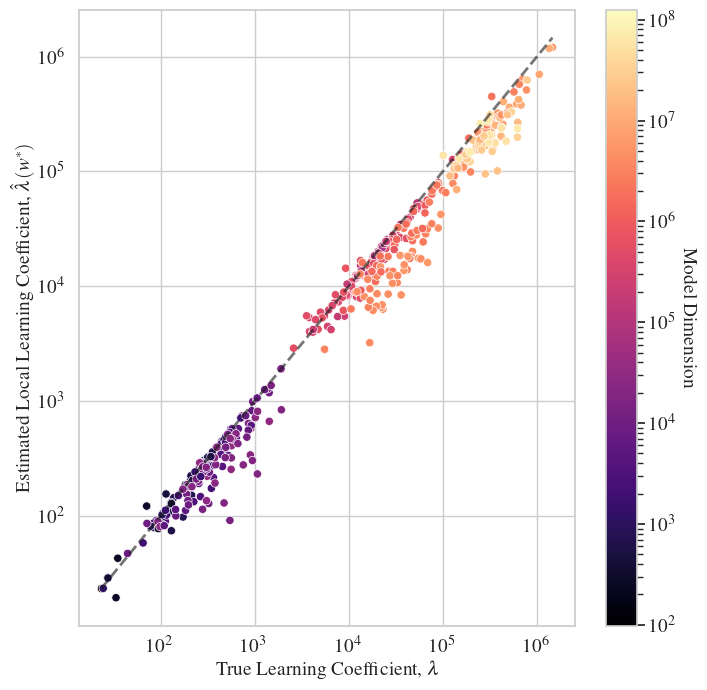

In [3]:
df = df_data
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
cmap = "magma"

vals = np.linspace(df["true_lambda"].min(), df["true_lambda"].max(), num=50)
ax.plot(vals, vals, "k--", linewidth=2, alpha=0.6)
sns.scatterplot(
    data=df, 
    x="true_lambda", 
    y="lambdahat_with_burnin", 
    hue="model_dim", 
    hue_norm=LogNorm(), 
    palette=cmap, 
    ax=ax
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(df["model_dim"].min(), df["model_dim"].max()))
sm.set_array([])
ax.get_legend().remove()
cbar = ax.figure.colorbar(sm, ax=ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Model Dimension', rotation=270)

ax.set_xlabel("True Learning Coefficient, $\lambda$")
ax.set_ylabel("Estimated Local Learning Coefficient, $\hat{\lambda}(w^*)$")
ax.set_xscale("log")
ax.set_yscale("log")
savefig_fn(fig, "lambdahat_vs_lambda.pdf")


# Linear-scale $\hat{\lambda}$-vs-$\lambda$

Saving file at: ./images/autogenerated/lambdahat_vs_lambda_linearscale.pdf


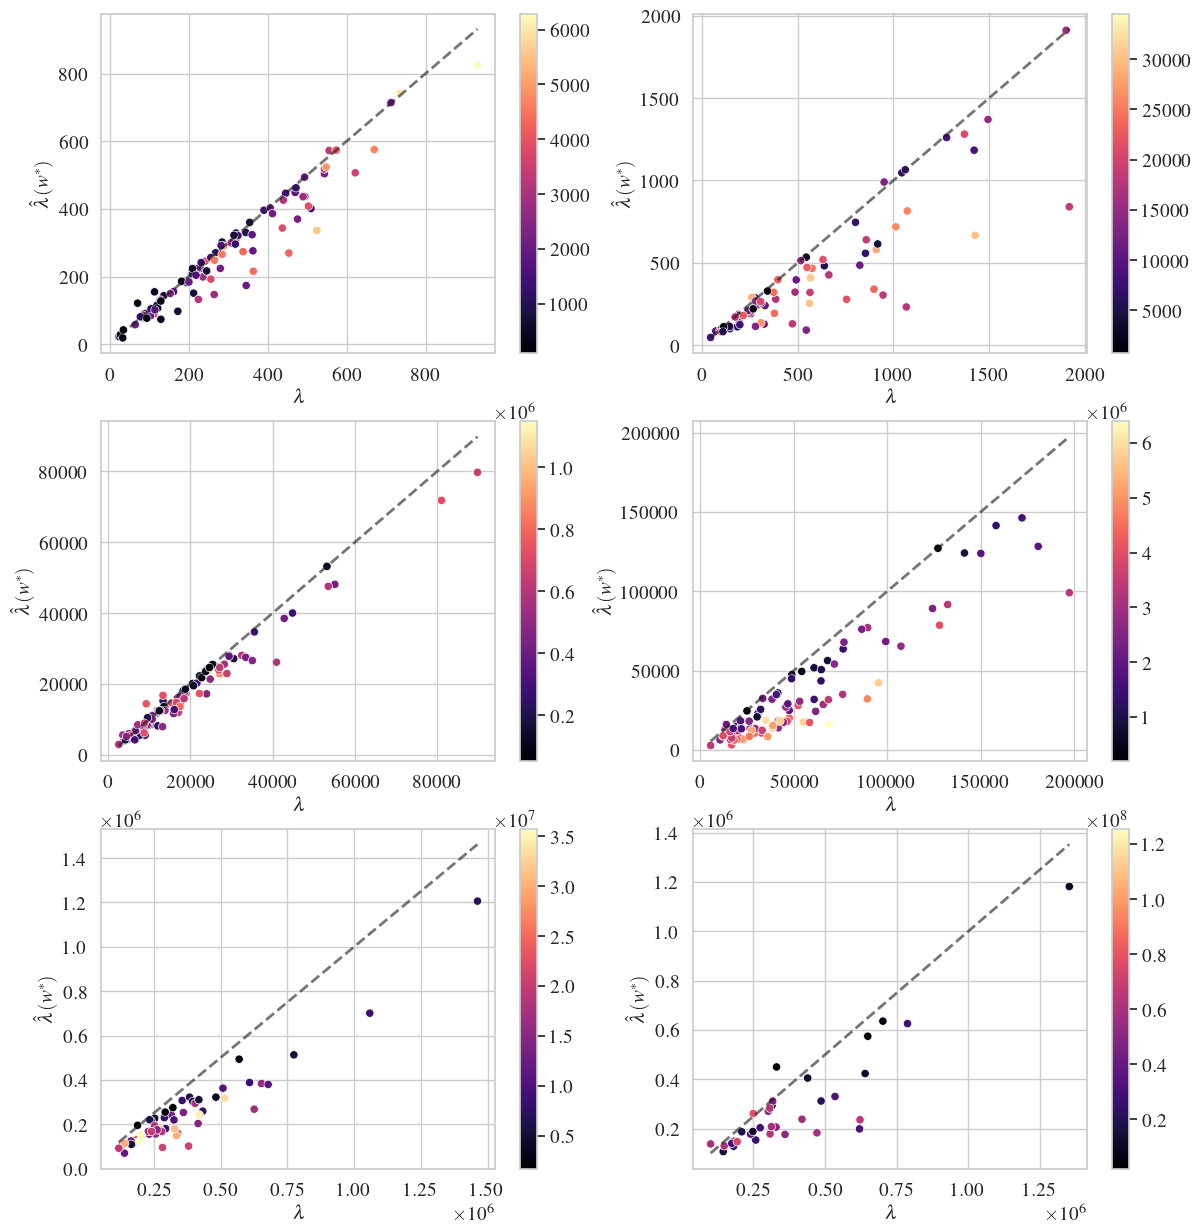

In [4]:
df_plot = df_data
group = df_plot.groupby("name")
cmap = "magma"

num_plot = len(group.groups)
nrows = 3
ncols = num_plot // nrows + int(num_plot % nrows != 0)
fig, axes = plt.subplots(nrows, ncols, figsize=(7 * ncols, 5 * nrows))
axes = np.ravel(axes)

for i, (name, df) in enumerate(group):
    ax = axes[i]
    vals = np.linspace(df["true_lambda"].min(), df["true_lambda"].max(), num=50)
    ax.plot(vals, vals, "k--", linewidth=2, alpha=0.6)
    sns.scatterplot(
        data=df, 
        x="true_lambda", 
        y="lambdahat_with_burnin", 
        hue="model_dim", 
        # hue_norm=LogNorm(), 
        palette=cmap, 
        ax=ax
    )

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(df["model_dim"].min(), df["model_dim"].max()))
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm, ax=ax)

    ax.set_xlabel("$\lambda$")
    ax.set_ylabel("$\hat{\lambda}(w^*)$")
savefig_fn(fig, "lambdahat_vs_lambda_linearscale.pdf")

# $\hat{\lambda}$-vs-$\lambda$ at trained parameter

Saving file at: ./images/autogenerated/lambdahat_vs_lambda_trained_param.pdf


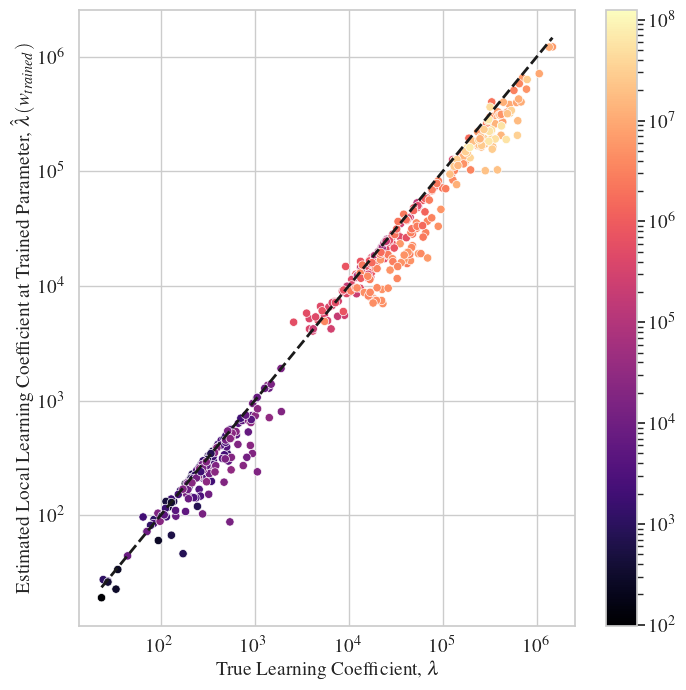

In [5]:
df = df_data
df = df[df["do_training"]]
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
cmap = "magma"

vals = np.linspace(df["true_lambda"].min(), df["true_lambda"].max(), num=50)
ax.plot(vals, vals, "k--", linewidth=2)
sns.scatterplot(
    data=df, 
    x="true_lambda", 
    y="lambdahat_trained_with_burnin", 
    hue="model_dim", 
    hue_norm=LogNorm(), 
    palette=cmap, 
    ax=ax
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(df["model_dim"].min(), df["model_dim"].max()))
sm.set_array([])
ax.get_legend().remove()
ax.figure.colorbar(sm, ax=ax)

ax.set_xlabel("True Learning Coefficient, $\lambda$")
ax.set_ylabel("Estimated Local Learning Coefficient at Trained Parameter, $\hat{\lambda}(w_{trained})$")
ax.set_xscale("log")
ax.set_yscale("log")
savefig_fn(fig, "lambdahat_vs_lambda_trained_param.pdf")


# Multiplicity 

Saving file at: ./images/autogenerated/multiplicity_barchart.pdf


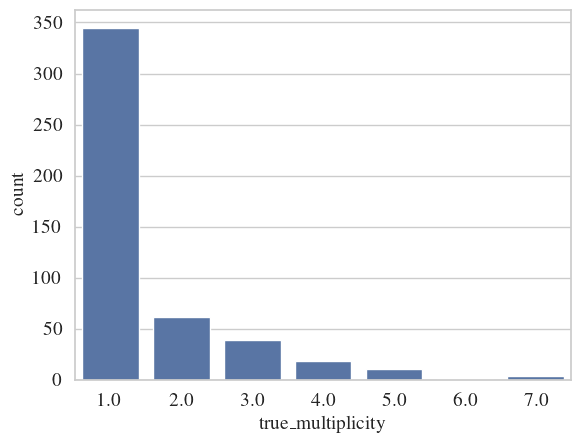

In [6]:
df = df_data
fig, ax = plt.subplots()
sns.countplot(data=df, x="true_multiplicity", ax=ax)
savefig_fn(fig, "multiplicity_barchart.pdf")

# Loss Trace

Saving file at: ./images/autogenerated/loss_trace_timeseries.pdf


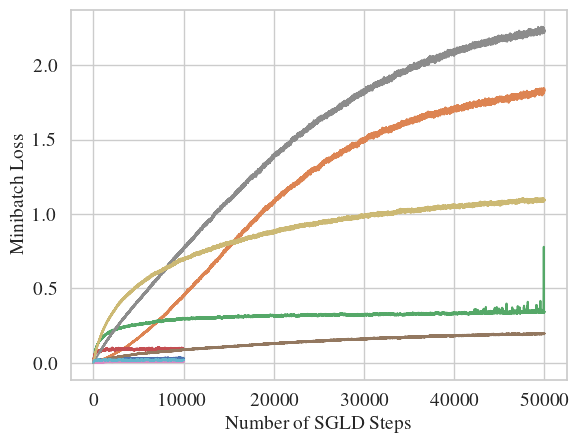

In [7]:
df = df_data
df = df[~np.isnan(df["lambdahat"])]
fig, ax = plt.subplots()

indices = np.random.randint(0, df.shape[0], size=10)
for index in indices: 
    sample_loss_trace = np.array(df.iloc[index]["loss_trace"])
    n = df.iloc[index]["num_training_data"]
    nsamples = len(sample_loss_trace)
    ax.plot(list(range(nsamples)), sample_loss_trace)
ax.set_xlabel("Number of SGLD Steps")
ax.set_ylabel("Minibatch Loss")
savefig_fn(fig, "loss_trace_timeseries.pdf")

# MALA acceptance probabilities

432 0.7167162143846246
457 0.9380308949737577
475 0.9027575363367214
348 0.8213042763970793
160 0.9308726182579994
Saving file at: ./images/autogenerated/mala_accept_prob_trace.pdf


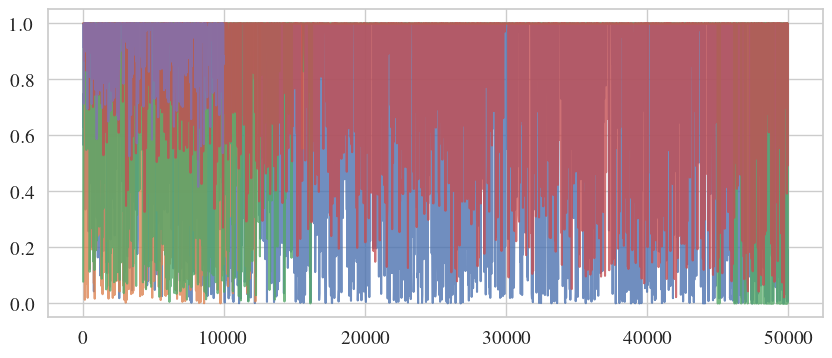

In [8]:
df = df_data
df = df[~np.isnan(df["lambdahat"])]

indices = np.random.choice(df.shape[0], size=5, replace=False)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
for index in indices:
    probs = np.array(df.iloc[index]["mala_acceptance_probs"])
    print(index, np.mean(probs[:, 1]))    
    ax.plot(probs[:, 0], probs[:, 1], alpha=0.8)

savefig_fn(fig, "mala_accept_prob_trace.pdf")

Saving file at: ./images/autogenerated/mean_mala_acceptprobs_histogram.pdf


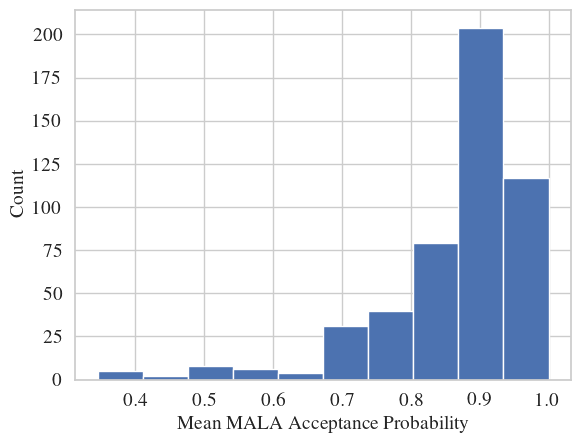

In [9]:
df = df_data
df = df[~np.isnan(df["lambdahat"])]
fig, ax = plt.subplots()

probs = [np.array(x)[:, 1].mean() for x in df["mala_acceptance_probs"]]

ax.hist(probs)
ax.set_xlabel("Mean MALA Acceptance Probability")
ax.set_ylabel("Count")
savefig_fn(fig, "mean_mala_acceptprobs_histogram.pdf")

# Rescaling-invariant Experiment plots

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_71505/3535090474.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('magma', 4 * len(filepaths))


Saving file at: ./images/autogenerated/rescaling_invariance_lambdahat_vs_scale.pdf


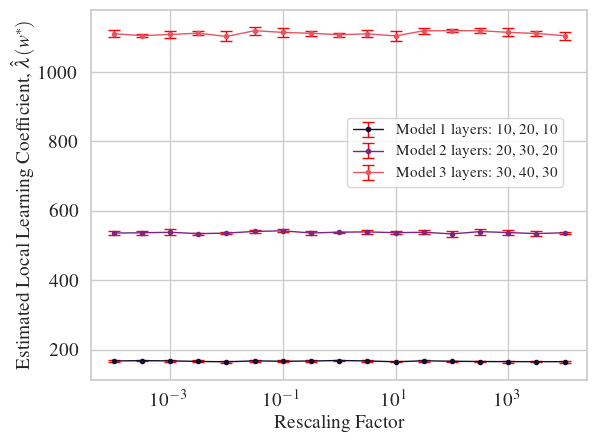

In [10]:
fig, ax = plt.subplots()
filepaths = [
    ("./data/llc_rescaling_results.json",   [10, 20, 10]),
    ("./data/llc_rescaling_results_2.json", [20, 30, 20]), 
    ("./data/llc_rescaling_results_3.json", [30, 40, 30]), 
]
cmap = mpl.cm.get_cmap('magma', 4 * len(filepaths))
for i, (filepath, layers) in enumerate(filepaths):
    with open(filepath) as infile:
        results = json.load(infile)
        scaling_factors = results["scaling_factors"]
        lambdahats = np.array(results["lambdahats"])

    meanvals = lambdahats.mean(axis=1)
    stds = lambdahats.std(axis=1)
    layer_str = ', '.join([str(x) for x in layers])
    ax.errorbar(
        scaling_factors, 
        meanvals, 
        yerr=stds, 
        fmt='o-', 
        capsize=4, 
        capthick=1, 
        ecolor='red', 
        color=cmap(3 * i + 1),
        linewidth=1, 
        markersize=3,
        label=f"Model {i + 1} layers: {layer_str}"
    )
    ax.set_xlabel("Rescaling Factor")
    ax.set_ylabel("Estimated Local Learning Coefficient, $\hat{\lambda}(w^*)$")
    ax.set_xscale("log")
    ax.legend(loc="best", bbox_to_anchor=(0.5, 0.5))
    # ymin, ymax = ax.get_ylim()
    # factor = 1.5
    # ax.set_ylim(ymin / factor, ymax * factor)
    # for i in range(lambdahats.shape[1]):
    #     ax.plot(scaling_factors, lambdahats[:, i], "x", alpha=0.8, c="orange")

savefig_fn(fig, "rescaling_invariance_lambdahat_vs_scale.pdf")

# MALA vs SGLD plot

Saving file at: ./images/autogenerated/sampler_comparison_lambdahat.pdf
Saving file at: ./images/autogenerated/sampler_comparison_exectime.pdf


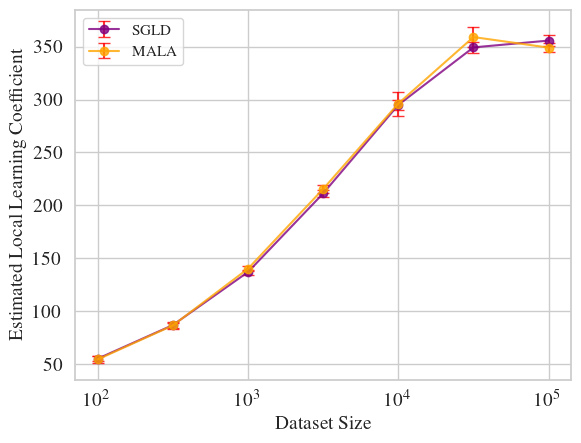

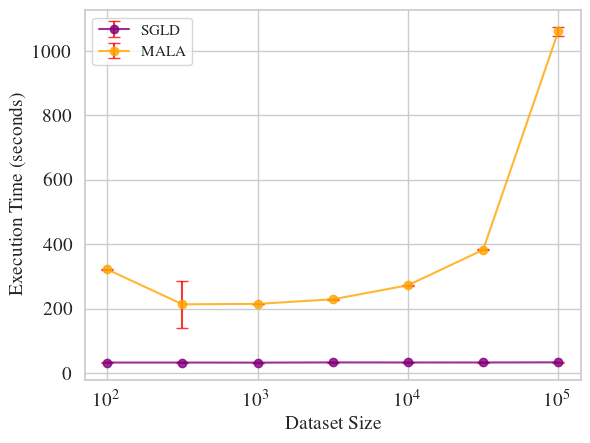

In [11]:
with open("./data/mala_v_sgld_results.json") as infile:
    results = json.load(infile)
    dataset_sizes = results["dataset_sizes"]


fig, ax = plt.subplots(1, 1)
color_dict = {
    "SGLD": "purple", 
    "MALA": "orange"
}
for method in color_dict:
    vals = np.array(results[method]["lambdas"])
    meanvals = vals.mean(axis=1)
    stds = vals.std(axis=1)
    ax.errorbar(
        dataset_sizes, 
        meanvals, 
        yerr=stds, 
        fmt='o-', 
        capsize=4, 
        capthick=1, 
        ecolor='red', 
        color=color_dict[method], 
        label=f"{method}", 
        alpha=0.8
    )
ax.legend()
ax.set_xlabel("Dataset Size")
ax.set_ylabel("Estimated Local Learning Coefficient")
ax.set_xscale("log")
savefig_fn(fig, "sampler_comparison_lambdahat.pdf")

fig, ax = plt.subplots(1, 1)
for method in color_dict:
    vals = np.array(results[method]["times"])
    meanvals = vals.mean(axis=1)
    stds = vals.std(axis=1)
    ax.errorbar(
        dataset_sizes, 
        meanvals, 
        yerr=stds, 
        fmt='o-', 
        capsize=4, 
        capthick=1, 
        ecolor='red', 
        color=color_dict[method], 
        label=f"{method}", 
        alpha=0.8
    )
ax.legend()
ax.set_xlabel("Dataset Size")
ax.set_ylabel("Execution Time (seconds)")
ax.set_xscale("log")
savefig_fn(fig, "sampler_comparison_exectime.pdf")

# Volume Scaling Cartoon

Saving file at: ./images/autogenerated/volume_scaling_cartoon.pdf


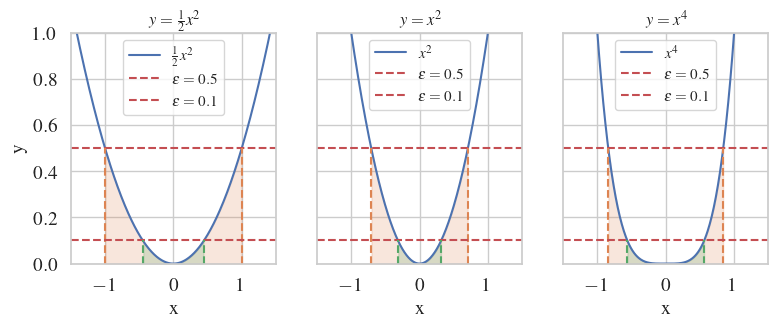

In [12]:
# Define the range of x values and two levels of epsilon
x_values = np.linspace(-1.5, 1.5, 400)
epsilon1 = 0.5
epsilon2 = 0.1

# Calculate y values for x^2, 1/2 x^2, and x^4
y_squared = x_values**2
y_half_squared = 0.5 * x_values**2
y_quartic = x_values**4

# Create the figure and axes objects
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

# Plot 1/2 x^2, vertical lines, and shaded area for two epsilon levels
axs[0].plot(x_values, y_half_squared, label='$\\frac{1}{2}x^2$')
for idx, epsilon in enumerate([epsilon1, epsilon2]):
    axs[0].axhline(y=epsilon, color='r', linestyle='--', label=f'$\epsilon = {epsilon}$')
    x_range = np.sqrt(2 * epsilon)
    axs[0].vlines(x=[-x_range, x_range], ymin=0, ymax=epsilon, color=f'C{idx+1}', linestyle='--')
    axs[0].fill_between(x_values, y_half_squared, where=(np.abs(x_values) <= x_range), alpha=0.2, color=f'C{idx+1}')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('$y = \\frac{1}{2}x^2$')
axs[0].legend()

# Plot x^2, vertical lines, and shaded area for two epsilon levels
axs[1].plot(x_values, y_squared, label='$x^2$')
for idx, epsilon in enumerate([epsilon1, epsilon2]):
    axs[1].axhline(y=epsilon, color='r', linestyle='--', label=f'$\epsilon = {epsilon}$')
    x_range = np.sqrt(epsilon)
    axs[1].vlines(x=[-x_range, x_range], ymin=0, ymax=epsilon, color=f'C{idx+1}', linestyle='--')
    axs[1].fill_between(x_values, y_squared, where=(np.abs(x_values) <= x_range), alpha=0.2, color=f'C{idx+1}')
axs[1].set_xlabel('x')
axs[1].set_title('$y = x^2$')
axs[1].legend()

# Plot x^4, vertical lines, and shaded area for two epsilon levels
axs[2].plot(x_values, y_quartic, label='$x^4$')
for idx, epsilon in enumerate([epsilon1, epsilon2]):
    axs[2].axhline(y=epsilon, color='r', linestyle='--', label=f'$\epsilon = {epsilon}$')
    x_range = epsilon**(1/4)
    axs[2].vlines(x=[-x_range, x_range], ymin=0, ymax=epsilon, color=f'C{idx+1}', linestyle='--')
    axs[2].fill_between(x_values, y_quartic, where=(np.abs(x_values) <= x_range), alpha=0.2, color=f'C{idx+1}')
axs[2].set_xlabel('x')
axs[2].set_title('$y = x^4$')
axs[2].legend()

# Set the same x and y-axis limits for all subplots
for ax in axs:
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([0, 1])

savefig_fn(fig, "volume_scaling_cartoon.pdf")


# MISC

Saving file at: ./images/autogenerated/model_dimension_histogram.pdf


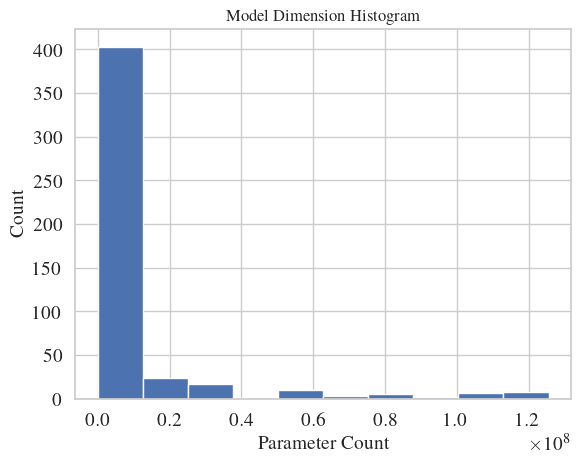

In [13]:
fig, ax = plt.subplots()
ax.hist(df_data["model_dim"])
ax.set_title("Model Dimension Histogram");
ax.set_xlabel("Parameter Count")
ax.set_ylabel("Count")
# ax.set_xscale("log")
savefig_fn(fig, "model_dimension_histogram.pdf")

lambdahat
False    496
True      39
Name: count, dtype: int64


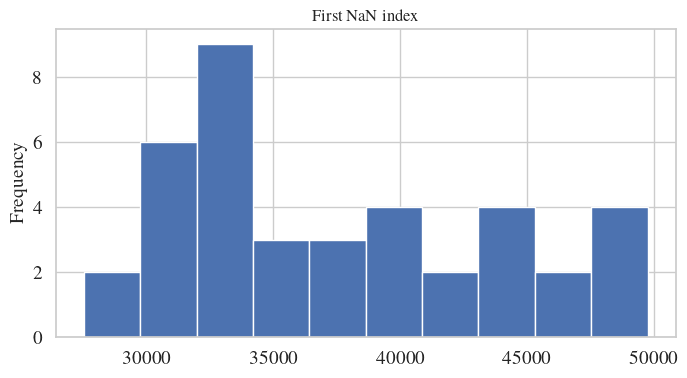

In [14]:
nan_count = np.isnan(df_data["lambdahat"]).value_counts()
print(nan_count)

if True in nan_count.index:
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    df_data["first_nan_index"].plot(kind="hist", ax=ax)
    ax.set_title("First NaN index");

Saving file at: ./images/autogenerated/lambdahat_relative_error_histogram.pdf
Saving file at: ./images/autogenerated/lambdahat_relative_error_scatterplot.pdf


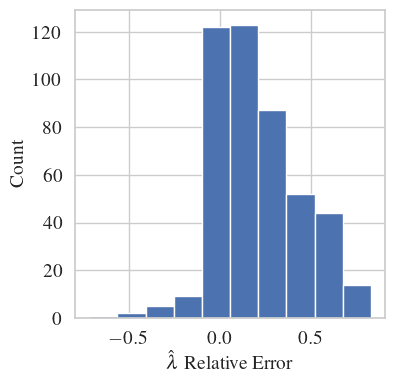

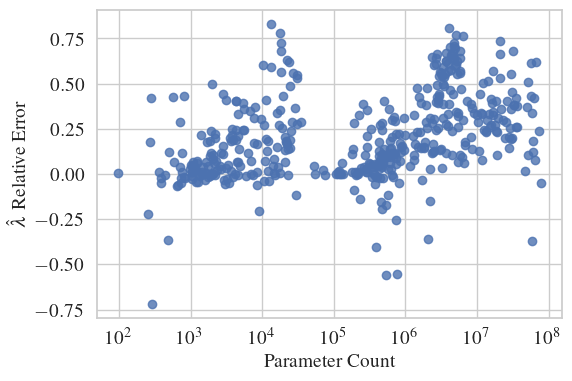

In [15]:
df = df_data
df["lambdahat_relative_error"] = (df["true_lambda"] - df["lambdahat_with_burnin"]) / df["true_lambda"]
fig, ax= plt.subplots(1, 1, figsize=(4, 4))
ax.hist(df["lambdahat_relative_error"])
ax.set_xlabel("$\hat{\lambda}$ Relative Error")
ax.set_ylabel("Count")
savefig_fn(fig, "lambdahat_relative_error_histogram.pdf")

fig, ax= plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(df["model_dim"], df["lambdahat_relative_error"], alpha=0.8)
ax.set_xscale("log")
ax.set_xlabel("Parameter Count")
ax.set_ylabel("$\hat{\lambda}$ Relative Error")
savefig_fn(fig, "lambdahat_relative_error_scatterplot.pdf")


Text(0.5, 0, 'Number of DLN Hidden Layers')

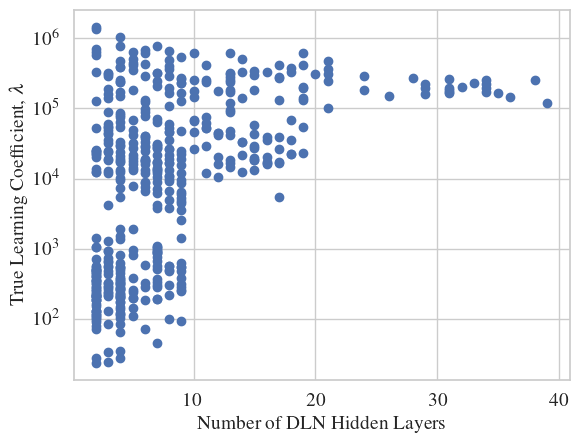

In [16]:
df = df_data
fig, ax = plt.subplots()
ax.scatter(df["num_layers"], df["true_lambda"])
ax.set_yscale("log")
ax.set_ylabel("True Learning Coefficient, $\lambda$")
ax.set_xlabel("Number of DLN Hidden Layers")


Text(0.5, 0, 'Parameter Count')

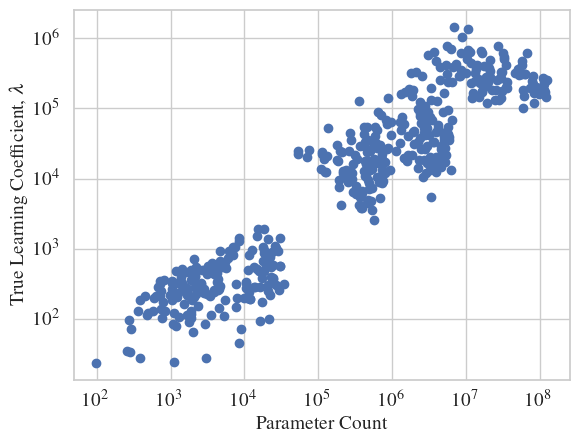

In [17]:
df = df_data
fig, ax = plt.subplots()
ax.scatter(df["model_dim"], df["true_lambda"])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("True Learning Coefficient, $\lambda$")
ax.set_xlabel("Parameter Count")


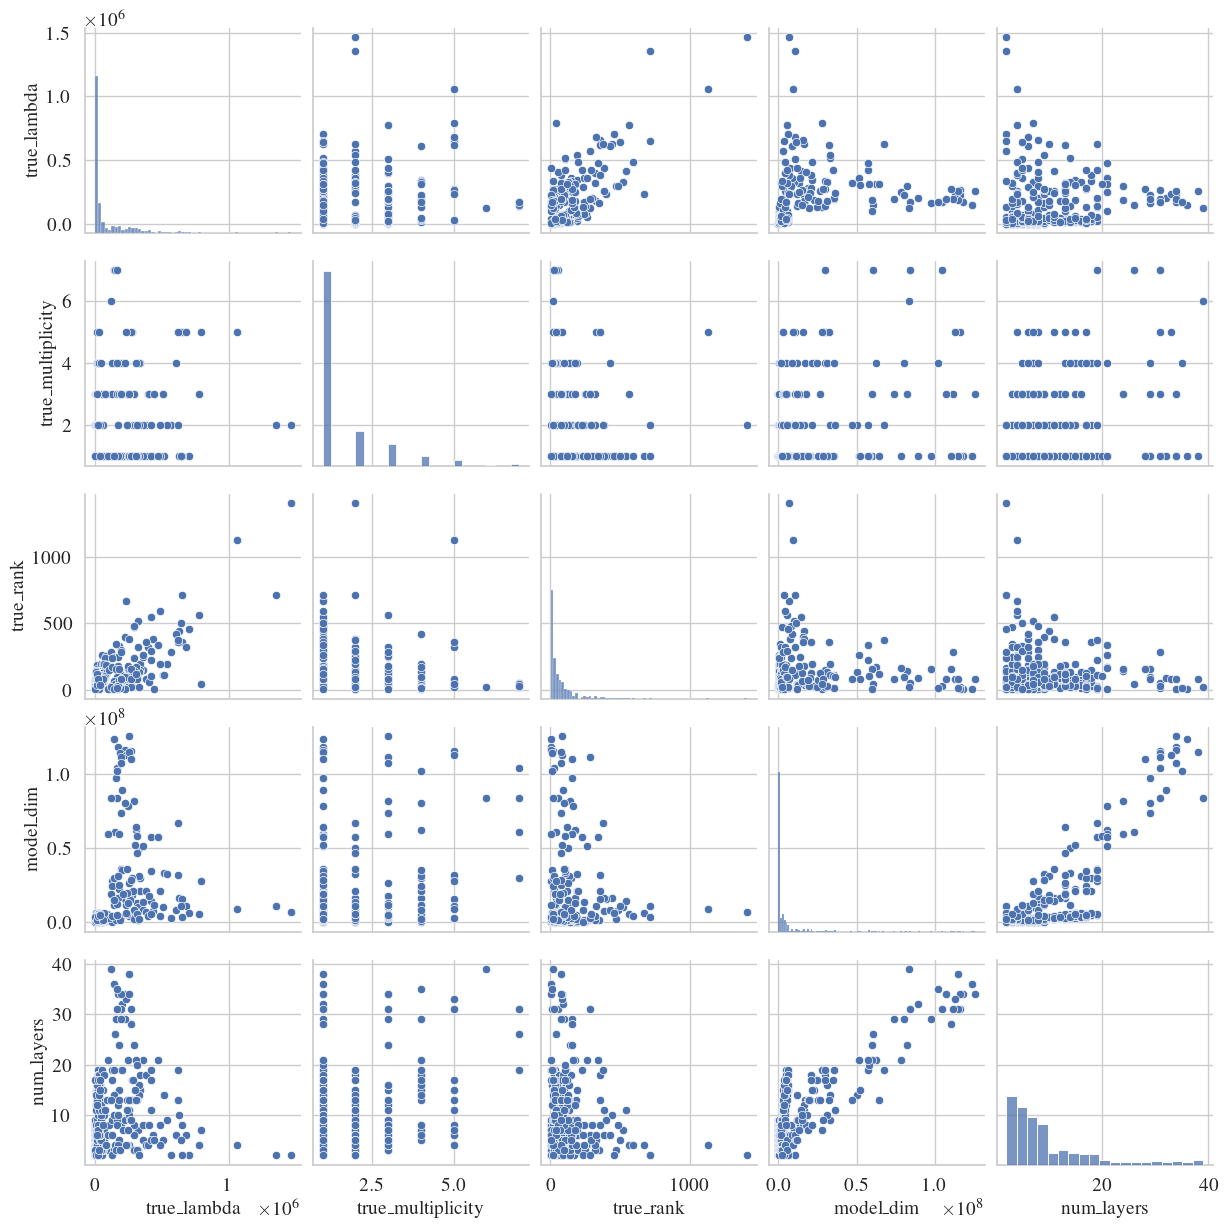

In [18]:
df = df_data[["true_lambda", "true_multiplicity", "true_rank", "model_dim", "num_layers", ]]
sns.pairplot(data=df)

Saving file at: ./images/autogenerated/numlayer_vs_lambda_scatterplot.pdf


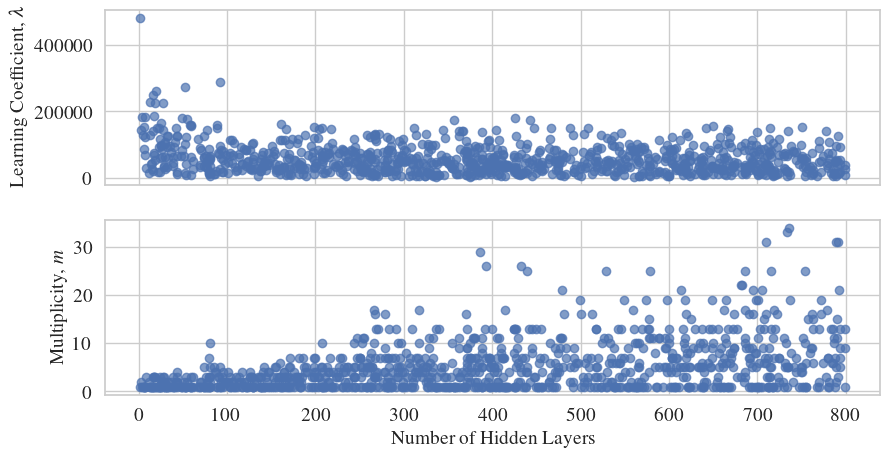

In [19]:
WIDTHMIN, WIDTHMAX = 100, 2000
NLAYERMIN, NLAYERMAX = 2, 800
NUMEXPT = 1000
data = []

np.random.seed(0)
for i in range(NUMEXPT):
    num_layer = np.random.randint(NLAYERMIN, NLAYERMAX)
    layer_widths = list(np.random.randint(WIDTHMIN, WIDTHMAX, size=num_layer))
    input_dim = np.random.randint(WIDTHMIN, WIDTHMAX)
    all_widths = [input_dim] + layer_widths
    true_rank = np.random.randint(0, min(all_widths))
    model_dim = sum(all_widths[i-1] * all_widths[i] for i in range(1, len(all_widths)))

    true_lambda, true_multiplicity = true_dln_learning_coefficient(
        true_rank, 
        layer_widths, 
        input_dim, 
        verbose=False
    )
    data.append([num_layer, np.mean(all_widths), true_rank, model_dim, true_lambda, true_multiplicity])

df = pd.DataFrame(data, columns=["num_layer", "avg_width", "true_rank", "model_dim", "true_lambda", "true_multiplicity"])
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax = axes[0]
ax.plot(df["num_layer"], df["true_lambda"], "bo", alpha=0.7)
# ax.set_xlabel("Number of Hidden Layers")
ax.set_ylabel("Learning Coefficient, $\lambda$")

ax = axes[1]
ax.plot(df["num_layer"], df["true_multiplicity"], "bo", alpha=0.7)
ax.set_xlabel("Number of Hidden Layers")
ax.set_ylabel("Multiplicity, $m$")
savefig_fn(fig, "numlayer_vs_lambda_scatterplot.pdf")

Saving file at: ./images/autogenerated/numlayer_vs_lambda_multiplicity_constwidth.pdf


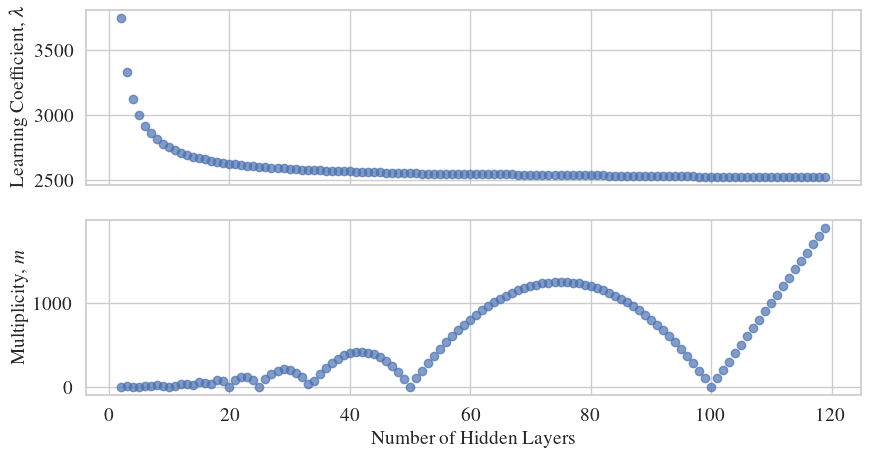

In [20]:
width = 100
data = []
for num_layer in range(2, 120, 1):
    layer_widths = [width] * num_layer
    input_dim = width
    all_widths = [input_dim] + layer_widths
    model_dim = sum(all_widths[i-1] * all_widths[i] for i in range(1, len(all_widths)))
    true_rank = 0
    true_lambda, true_multiplicity = true_dln_learning_coefficient(
        true_rank, 
        layer_widths, 
        input_dim, 
        verbose=False
    )
    data.append([num_layer, np.mean(all_widths), true_rank, model_dim, true_lambda, true_multiplicity])

df = pd.DataFrame(data, columns=["num_layer", "avg_width", "true_rank", "model_dim", "true_lambda", "true_multiplicity"])
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax = axes[0]
ax.plot(df["num_layer"], df["true_lambda"], "bo", alpha=0.7)
# ax.set_xlabel("Number of Hidden Layers")
ax.set_ylabel("Learning Coefficient, $\lambda$")

ax = axes[1]
ax.plot(df["num_layer"], df["true_multiplicity"], "bo", alpha=0.7)
ax.set_xlabel("Number of Hidden Layers")
ax.set_ylabel("Multiplicity, $m$")

savefig_fn(fig, "numlayer_vs_lambda_multiplicity_constwidth.pdf")

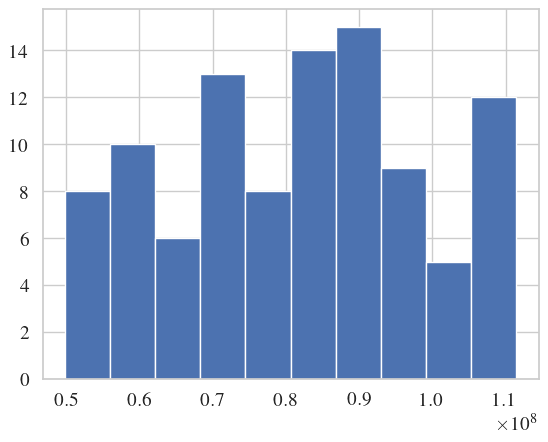

In [21]:
WIDTHMIN, WIDTHMAX = 1000, 2000
NLAYERMIN, NLAYERMAX = 25, 50
NUMEXPT = 100
data = []

np.random.seed(0)
dims = []
for i in range(NUMEXPT):
    num_layer = np.random.randint(NLAYERMIN, NLAYERMAX)
    layer_widths = list(np.random.randint(WIDTHMIN, WIDTHMAX, size=num_layer))
    input_dim = np.random.randint(WIDTHMIN, WIDTHMAX)
    all_widths = [input_dim] + layer_widths
    true_rank = np.random.randint(0, min(all_widths))
    model_dim = sum(all_widths[i-1] * all_widths[i] for i in range(1, len(all_widths)))
    dims.append(model_dim)
plt.hist(dims);

# Saddle-to-Saddle dynamics

Saving file at: ./images/autogenerated/dln_saddletosaddle_transition_0.pdf
Saving file at: ./images/autogenerated/dln_saddletosaddle_transition_1.pdf
Saving file at: ./images/autogenerated/dln_saddletosaddle_transition_2.pdf
Saving file at: ./images/autogenerated/dln_saddletosaddle_transition_3.pdf
Saving file at: ./images/autogenerated/dln_saddletosaddle_transition_4.pdf


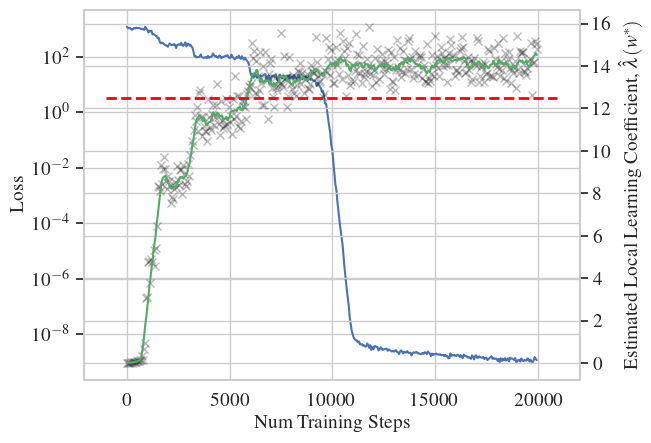

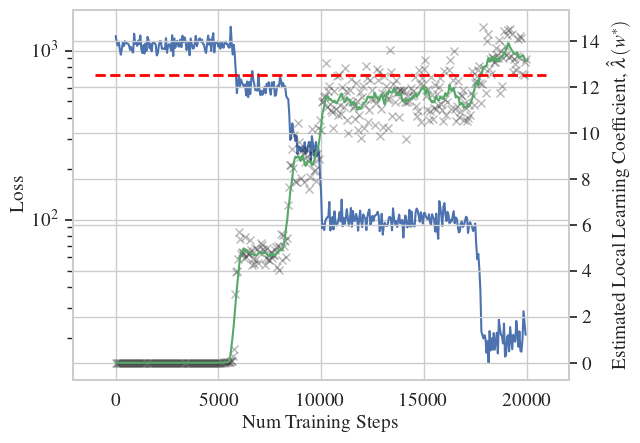

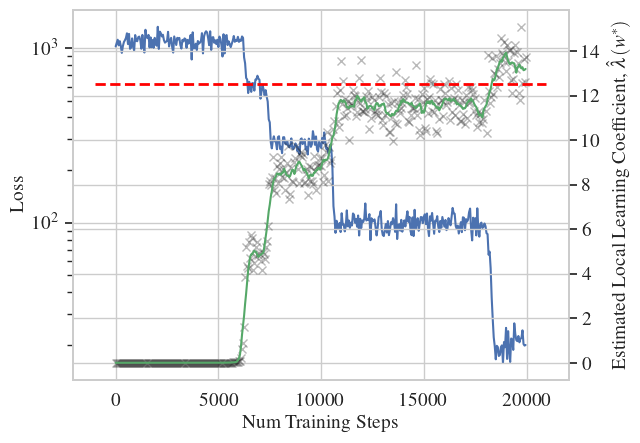

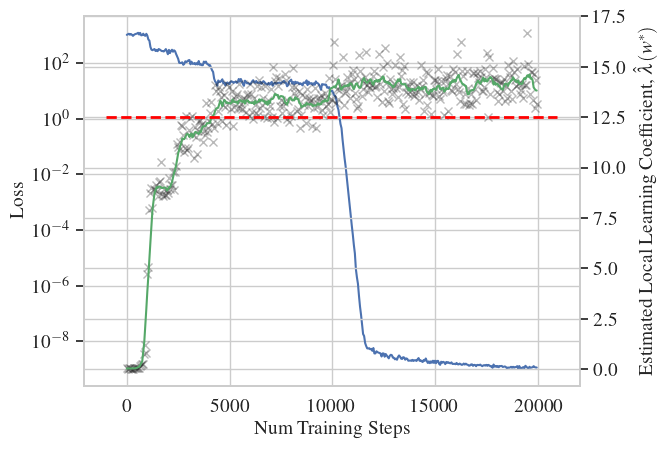

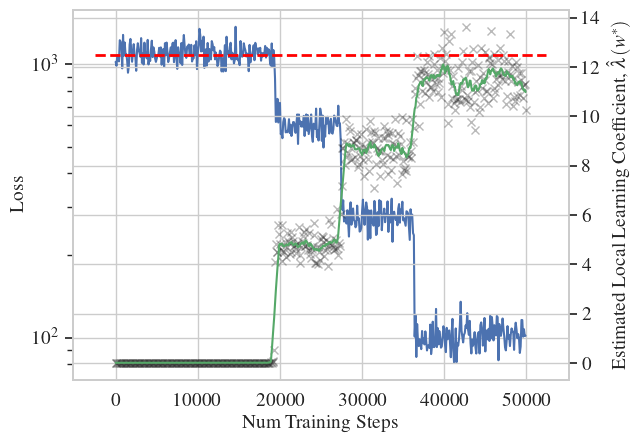

In [28]:
from pymongo import MongoClient

def running_mean(data, window_size=10):
    if window_size % 2 == 0:
        left_pad = window_size // 2
        right_pad = window_size // 2 - 1
    else:
        left_pad = right_pad = window_size // 2

    # Reflect the data for boundary cases
    pad_left = data[:left_pad][::-1]
    pad_right = data[-right_pad:][::-1]
    padded_data = np.concatenate([pad_left, data, pad_right])

    kernel = np.ones(window_size) / window_size
    return np.convolve(padded_data, kernel, mode='valid')


client = MongoClient('mongodb://localhost:27017/')
db = client['dln_saddle_dynamics']
collection = db['runs']


expts = [
    "test", 
    "test2",
    "test4",
    "test5", 
    "test6"
]
for i, EXPT_NAME in enumerate(expts):
# EXPT_NAME = "test"
# EXPT_NAME = "test2"

    query = {
        "config.expt_name": EXPT_NAME, 
        "status": "COMPLETED", 
    }
    projection = {
        "epsilon": "$config.sgld_config.epsilon", 
        "num_steps": "$config.sgld_config.num_steps",
        "input_dim": "$config.input_dim",
        "num_training_data": "$config.num_training_data",
        "itemp": "$config.itemp",
        "info": "$info"
    }
    doc = collection.find_one(query)
    df = pd.DataFrame(doc["info"])
    fig, ax = plt.subplots()
    ax.plot(df["t"], df["train_loss"])
    ax.set_yscale("log")
    ax.set_ylabel("Loss")
    ax.set_xlabel("Num Training Steps")

    ax = ax.twinx()

    ax.plot(df["t"], np.clip(df["lambdahat"], a_min=0, a_max=np.inf), "kx", alpha=0.3, label="$\hat{\lambda}$")
    yvals = running_mean(df["lambdahat"])
    ax.plot(df["t"], yvals, "g-", label="$\hat{\lambda}$ running mean")
    ax.set_ylabel("Estimated Local Learning Coefficient, $\hat{\lambda}(w^*)$")

    xmin, xmax = ax.get_xlim()
    ax.hlines([df["true_lambda"].iloc[-1]], xmin=xmin, xmax=xmax, linestyles="dashed", linewidth=2, color="red")
    # ax.legend()
    savefig_fn(fig, f"dln_saddletosaddle_transition_{i}.pdf")


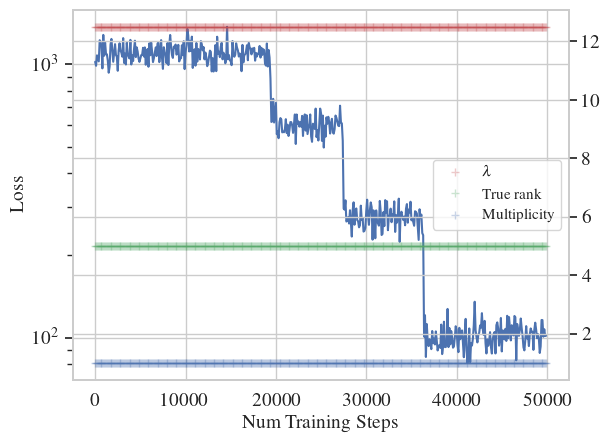

In [23]:

fig, ax = plt.subplots()
ax.plot(df["t"], df["train_loss"])
ax.set_yscale("log")
ax.set_ylabel("Loss")
ax.set_xlabel("Num Training Steps")

ax = ax.twinx()
ax.plot(df["t"], df["true_lambda"], "r+", alpha=0.3, label="$\lambda$")
ax.plot(df["t"], df["true_rank"], "g+", alpha=0.3, label="True rank")
ax.plot(df["t"], df["true_multiplicity"], "b+", alpha=0.3, label="Multiplicity")
ax.legend()


0_rand_rank_batch500_width5-50_layer2-5_trainTrue_n100000_eps5e-07_nstep10000_202402012059
1_rand_rank_batch500_width5-100_layer2-10_trainTrue_n100000_eps5e-07_nstep10000_202402012140
2_rand_rank_batch500_width50-500_layer2-10_trainTrue_n1000000_eps1e-07_nstep50000_202402010801
3_rand_rank_batch500_width100-1000_layer2-20_trainTrue_n1000000_eps2e-08_nstep50000_202401281611
4_rand_rank_batch500_width500-2000_layer2-20_trainTrue_n1000000_eps2e-08_nstep50000_202402010823
5_rand_rank_batch500_width500-3000_layer2-40_trainTrue_n1000000_eps2e-08_nstep50000_202401300014
Saving file at: ./images/autogenerated/tuning_run_mala_acceptance_traceplot.pdf


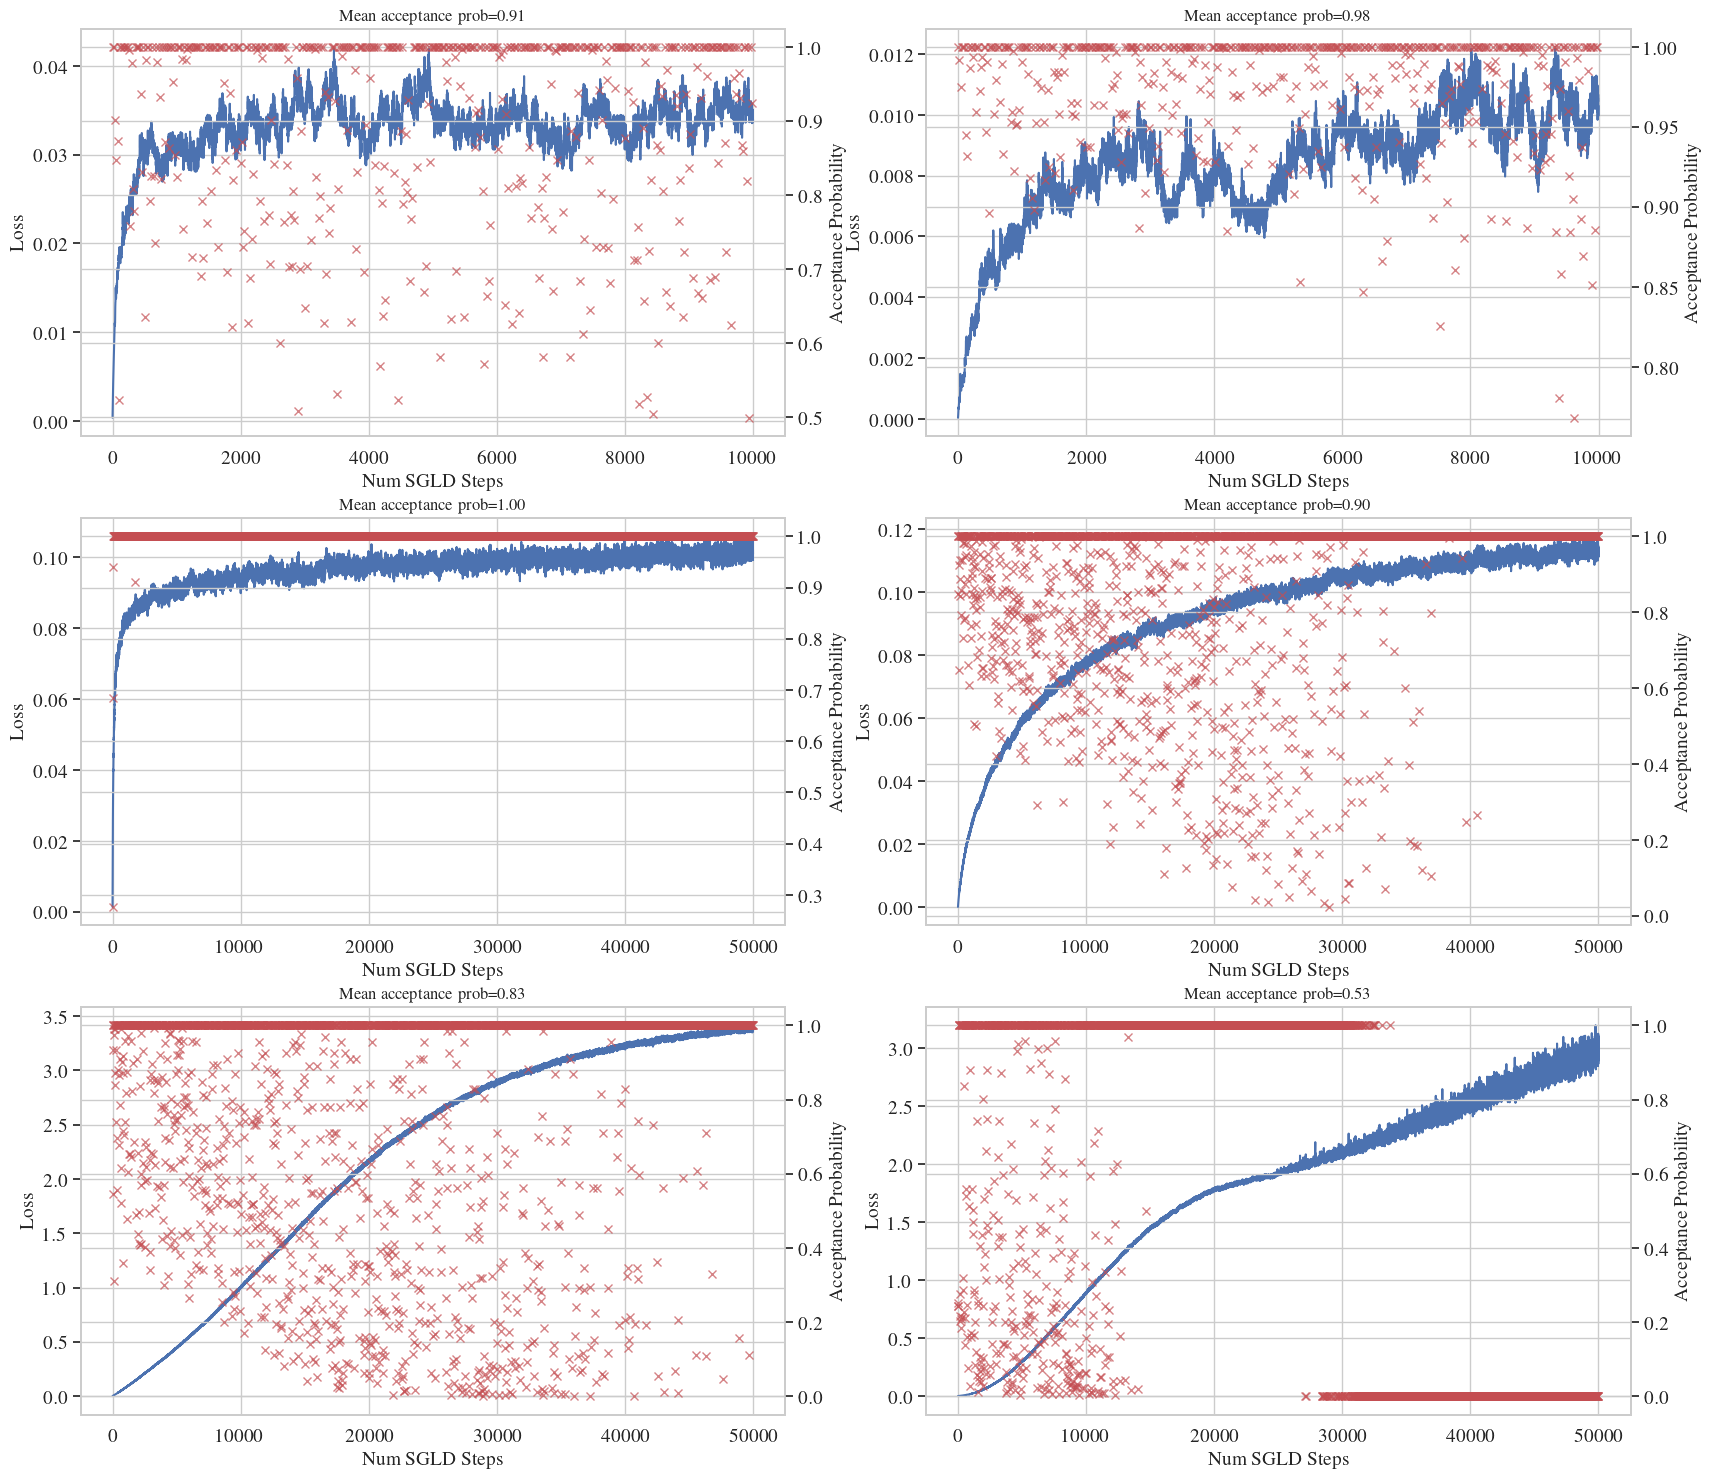

In [24]:
df_plot = df_data
group = df_plot.groupby("name")
index = 1

num_plot = len(group.groups)
nrows = 3
ncols = num_plot // nrows + int(num_plot % nrows != 0)
fig, axes = plt.subplots(nrows, ncols, figsize=(10 * ncols, 6 * nrows))
axes = np.ravel(axes)

for i, (name, df) in enumerate(group):
    ax = axes[i]
    print(name)
    loss_trace = np.array(df["loss_trace"].iloc[index])
    probs = np.array(df["mala_acceptance_probs"].iloc[index])
    ax.plot(loss_trace, label="loss trace")
    ax.set_ylabel("Loss")
    ax.set_xlabel("Num SGLD Steps")
    ax.set_title(f"Mean acceptance prob={np.mean(probs[:, 1]):.2f}")


    ax1 = ax.twinx()
    ax1.plot(probs[:, 0], probs[:, 1], "rx", label="acceptance probs", alpha=0.7)
    ax1.set_ylabel("Acceptance Probability")
    ax1.set_xlabel("Num SGLD Steps")
    # ax1.legend();


savefig_fn(fig, "tuning_run_mala_acceptance_traceplot.pdf")